In [1]:
# default_exp dict_gmaps

# dict_nGmaps

> Implementation based on dicts

In [2]:
# hide
from nbdev.showdoc import *

In [3]:
# export

from collections import defaultdict
from itertools import chain, product
import logging


|  8 |  2 |   3 |           3 |          7 | 
| 16 |  6 |   7 |          63 |        127 | 
| 32 | 14 |  15 |       16383 |      32767 | 
| 64 | 30 |  31 |  1073741823 | 2147483647 | 
11111  ... AND mask for corners
01010  ... AND mask for top and bottom borders
10101  ... AND mask for left and right borders
00000  ... AND mask for interior darts

11111111111111111111111110101000 ... x-mask for (at most) 32-bit integer numbers
11111111111111111111111101010000 ... y-mask for (at most) 32-bit integer numbers

 D# |   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 72 73 74 75 96 97 98 99 104 105 106 107 128 129 130 131 132 133 134 135 140 141 142 143 144 145 146 147 148 149 150 151 156 157 158 159 192 193 194 195 
---------------------------------------------------------------------------------------------------------------------------

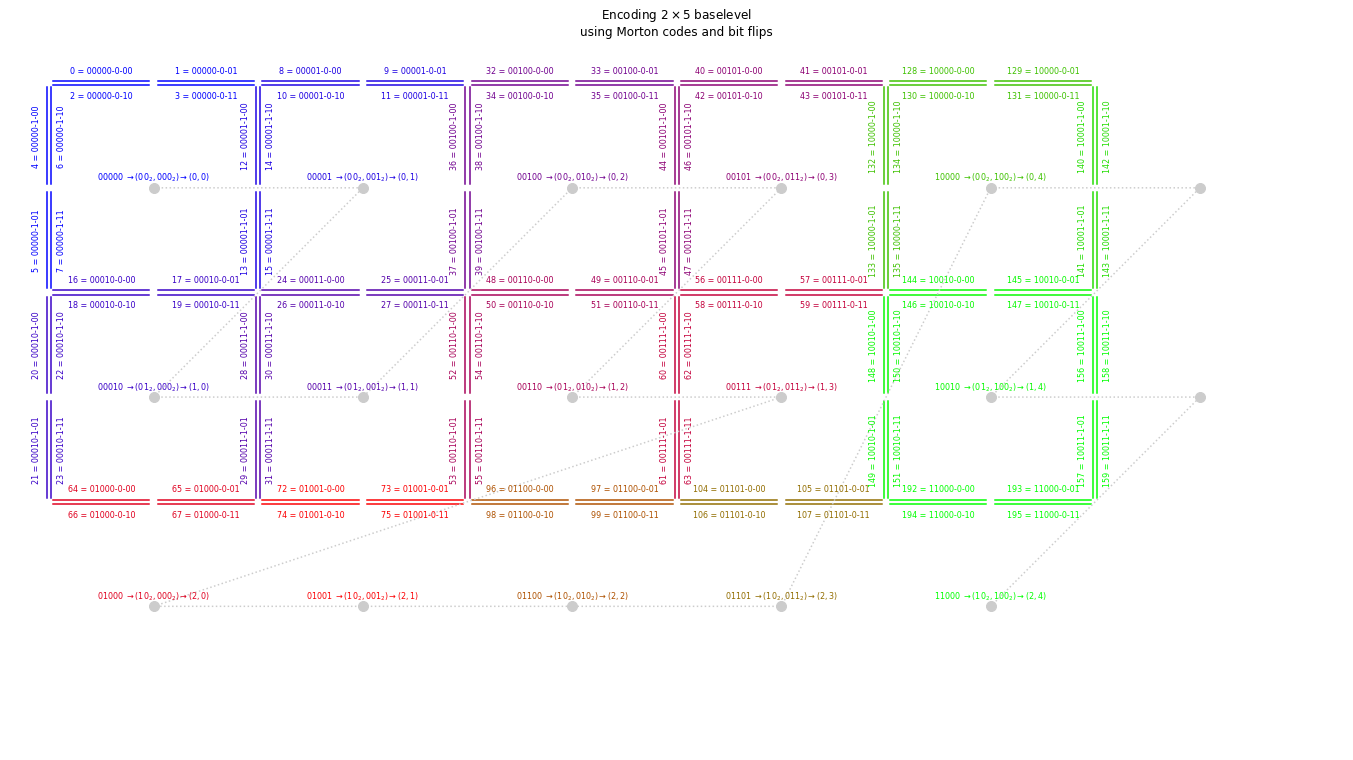

In [4]:
from implicit_dict import implicit_dict

In [5]:
# export

class dict_nGmap:
    
    def __init__(self, n):
        
        self.n = n
        
        self.darts = implicit_dict.get_set()
        self.alpha = [implicit_dict() for _ in range(n + 1)]
        self.marks = defaultdict(lambda:defaultdict(lambda:False))
        # self.marks[index][dart]
        
        """
            Added a tmp dict to create a tmp-Gmap to insert/expand it into the current one.
        """
        self.c = {}


        """
            That variable has the goal of increment itself whenever a new operation is computed
            (removal or contraction).
        """
        self.level = 0

        """
            I want to use the following dictionary to keep trace of the level for each dart in order
            to reconstruct also until a certain level that the user can indicate in input.
        """
        self.dart_level = {}

        """
            Considering the new version of the implementation using the canonical representation
            I need to use another list of the alphas to overcome the fact that I do not have the code
            for the implicitly econding of the base level.
        """
        self.custom_alpha = [dict() for _ in range(n + 1)]
        
        self.taken_marks = {-1}
        self.lowest_unused_dart_index = 0
        
    @classmethod
    def from_string(cls, string):
        lines = string.strip().split("\n")
        lines = [[int(k) for k in l.split(" ") if k != ""] for l in lines]
    
        return cls.from_list_of_lists(lines)
        
    @classmethod    
    def from_list_of_lists(cls, ll):
        n = len(ll) - 1
        d = len(ll[0])
        
        darts = set(ll[0])
        
        assert all(set(l) == darts for l in ll)
                
        my_nGmap = cls(n)
        my_nGmap.darts.update(darts)
        
        for alpha, l in zip(my_nGmap.alpha, ll):
            for a, b in zip(sorted(darts), l):
                alpha[a] = b
                
        my_nGmap.lowest_unused_dart_index = max(darts) + 1
        
        return my_nGmap
    
    @property
    def is_valid(self):
        """
        checks condition 2 and 3 from definition 1
        (condition 1 is always true as a computer probably has finite memory)
        """
        for dart in self.darts:
            for alpha in self.alpha:
                if alpha[alpha[dart]] != dart:
                    return False
            for i in range(0, self.n - 1): # n-1 not included
                alpha1 = self.alpha[i]
                for j in range(i + 2, self.n + 1): # n+1 again not included
                    alpha2 = self.alpha[j]
                    if alpha1[alpha2[alpha1[alpha2[dart]]]] != dart:
                        return False
        return True
    
    def reserve_mark(self):
        """
        algorithm 2
        """
        i = max(self.taken_marks) + 1
        self.taken_marks.add(i)
        return i
    
    def free_mark(self, i):
        """
        algorithm 3
        also includes deleting all these marks, making it safe to call everytime
        """
        del self.marks[i]
        self.taken_marks.remove(i)    
    
    def is_marked(self, d, i):
        """
        algorithm 4
        d ... dart
        i ... mark index
        """
        return self.marks[i][d]
    
    def mark(self, d, i):
        """
        algorithm 5
        d ... dart
        i ... mark index
        """
        self.marks[i][d] = True
        
    def unmark(self, d, i):
        """
        algorithm 6
        d ... dart
        i ... mark index
        """
        # same as bla = False
        del self.marks[i][d]
    
    def mark_all(self, i):
        for d in self.darts:
            self.mark(d, i)
    
    def unmark_all(self, i):
        del self.marks[i]
    
    def ai(self, i, d):
        return self.alpha[i][d]
    
    def set_ai(self, i, d, d1):
        assert 0 <= i <= self.n
        #self.custom_alpha[i][d] = d1
        #print(f'd -> {d}\nd1 -> {d1}')
        #self.dart_level[d] = self.level
        self.alpha[i][d] = d1
        
    def _remove_dart(self, d):

        """
            We are removing the dart from the set.
        """
        self.darts.remove(d)

        """
            We are removing the dart from every alpha
        """
        for i in self.all_dimensions:
            del self.alpha[i][d]
    
    def orbit(self, sequence, d):
        """
        algorithm 7
        sequence ... valid list of dimensional indices
        d ... dart
        """
        ma = self.reserve_mark()
        self.mark_orbit(sequence, d, ma)
        orbit = self.marks[ma].keys()
        self.free_mark(ma)
        return orbit
    
    def mark_orbit(self, sequence, d, ma):
        """
        used as in algorithm 7 and 8 etc...
        sequence ... valid list of dimension indices
        d ... dart
        ma ... mark to use
        """
        P = [d]
        self.mark(d, ma)
        while P:
            cur = P.pop()
            for i in sequence:
                other = self.alpha[i][cur]
                if not self.is_marked(other, ma):
                    self.mark(other, ma)
                    P.append(other)
    
    def cell_i(self, i, dart):
        """iterator over i-cell of a given dart"""
        return self.orbit(self.all_dimensions_but_i(i), dart)

    def cell_0(self, dart):
        return self.cell_i(0, dart)
    def cell_1(self, dart):
        return self.cell_i(1, dart)
    def cell_2(self, dart):
        return self.cell_i(2, dart)
    def cell_3(self, dart):
        return self.cell_i(3, dart)
    def cell_4(self, dart):
        return self.cell_i(4, dart)
    
    def no_i_cells (self, i=None):
        """
        Counts
            i-cells,             if 0 <= i <= n
            connected components if i is None
        """
        assert i is None or 0 <= i <= self.n
        # return more_itertools.ilen (self.darts_of_i_cells(i))
        return sum ((1 for d in self.darts_of_i_cells(i)))

    @property
    def no_0_cells (self): return self.no_i_cells (0)
    @property
    def no_1_cells (self): return self.no_i_cells (1)
    @property
    def no_2_cells (self): return self.no_i_cells (2)
    @property
    def no_3_cells (self): return self.no_i_cells (3)
    @property
    def no_4_cells (self): return self.no_i_cells (4)
    @property
    def no_ccs     (self): return self.no_i_cells ( )
    
    def darts_of_i_cells(self, i = None):
        """
        algorithm 8
        """
        ma = self.reserve_mark()
        try:
            for d in self.darts:
                if not self.is_marked(d, ma):
                    yield d
                    self.mark_orbit(self.all_dimensions_but_i(i), d, ma)
        finally:
            self.free_mark(ma)
    
    def all_i_cells(self, i = None):
        for d in self.darts_of_i_cells(i):
            yield self.cell_i(i, d)
    
    def all_conected_components(self):
        return self.all_i_cells()
    
    def darts_of_i_cells_incident_to_j_cell(self, d, i, j):
        """
        algorithm 9
        """
        assert i != j
        ma = self.reserve_mark()
        try:
            for e in self.orbit(self.all_dimensions_but_i(j), d):
                if not self.is_marked(e, ma):
                    yield e
                    self.mark_orbit(self.all_dimensions_but_i(j), e, ma)
        finally:
            self.free_mark(ma)
        
    def darts_of_i_cells_adjacent_to_i_cell(self, d, i):
        """
        algorithm 10
        """
        ma = self.reserve_mark()
        try:
            for e in self.orbit(self.all_dimensions_but_i(i), d):
                f = self.alpha[i][e]
                if not self.is_marked(f, ma):
                    yield f
                    self.mark_orbit(self.all_dimensions_but_i(i), f, ma)
        finally:
            self.free_mark(ma)
        
    def all_dimensions_but_i (self, i=None):
        """Return a sorted sequence [0,...,n], without i, if 0 <= i <= n"""
        assert i is None or 0 <= i <= self.n
        return [j for j in range (self.n+1) if j != i]
    
    @property
    def all_dimensions(self):
        return self.all_dimensions_but_i()
    
    def is_i_free(self, i, d):
        """
        definiton 2 / algorithm 11
        """
        return self.alpha[i][d] == d
        
    def is_i_sewn_with(self, i, d):
        """
        definiton 2
        """
        d2 = self.alpha[i][d]
        return d != d2, d2
    
    def create_dart(self):
        """
        algorithm 12
        """
        d = self.lowest_unused_dart_index
        self.lowest_unused_dart_index += 1
        self.darts.add(d)
        for alpha in self.alpha:
            alpha[d] = d
        return d
    
    def remove_isolated_dart(self, d):
        """
        algorithm 13
        """
        assert self.is_isolated(d)
        self.remove_isolated_dart_no_assert(d)
        
    def remove_isolated_dart_no_assert(self, d):
        self.darts.remove(d)
        for alpha in self.alpha:
            del alpha[d]
    
    def is_isolated(self, d):
        for i in range(self.n + 1):
            if not self.is_i_free(i, d):
                return False
        return True
    
    def increase_dim(self):
        """
        algorithm 15 in place
        """
        self.n += 1
        self.alpha.append(dict((d,d) for d in self.darts))
        
    def decrease_dim(self):
        """
        algorithm 16 in place
        """
        assert all(self.is_i_free(self.n, d) for d in self.darts)
        self.decrease_dim_no_assert()
    
    def decrease_dim_no_assert(self):
        del self.alpha[self.n]
        self.n -= 1
    
    def index_shift(self, by):
        self.darts = {d + by for d in self.darts}
        self.alpha = [{k + by : v + by for k, v in a.items()} for a in self.alpha]
        for mark in self.marks:
            new_dict = {key + by : value for key, value in self.marks[mark].items()}
            self.marks[mark].clear()
            self.marks[mark].update(new_dict) #this is done to preserve default dicts
        self.lowest_unused_dart_index += by
        
    def merge(self, other):
        """
        algorithm 17 in place
        """
        assert self.n == other.n
        self.taken_marks.update(other.taken_marks)
        shift = max(self.darts) - min(other.darts) + 1
        other.index_shift(shift)
        
        self.darts.update(other.darts)
        for sa, oa in zip(self.alpha, other.alpha):
            sa.update(oa)
        for mk in other.marks:
            self.marks[mk].update(other.marks[mk])
        self.taken_marks.update(other.taken_marks)
        self.lowest_unused_dart_index = other.lowest_unused_dart_index
        
    def restrict(self, D):
        """
        algorithm 18
        """
        raise NotImplementedError #boring
    
    def sew_seq(self, i):
        """
        indices used in the sewing operations
        (0, ..., i - 2, i + 2, ..., n)
        """
        return chain(range(0, i - 1), range(i + 2, self.n + 1))
    
    def sewable(self, d1, d2, i):
        """
        algorithm 19
        tests wether darts d1, d2 are sewable along i
        returns bool
        """
        if d1 == d2 or not self.is_i_free(i, d1) or not self.is_i_free(i, d2):
            return False
        try:
            f = dict()
            for d11, d22 in strict_zip(self.orbit(self.sew_seq(i), d1), self.orbit(self.sew_seq(i), d2), strict = True):
                f[d11] = d22
                for j in self.sew_seq(i):
                    if self.alpha[j][d11] in f and f[self.alpha[j][d11]] != self.alpha[j][d22]:
                        return False
        except ValueError: #iterators not same length
            return False
        return True
    
    def sew(self, d1, d2, i):
        """
        algorithm 20
        """
        assert self.sewable(d1, d2, i)
        self.sew_no_assert(d1, d2, i)
        
    def sew_no_assert(self, d1, d2, i):
        for e1, e2 in strict_zip(self.orbit(self.sew_seq(i), d1), self.orbit(self.sew_seq(i), d2), strict = True):
            self.alpha[i][e1] = e2
            self.alpha[i][e2] = e1
    
    def unsew(self, d, i):
        """
        algorithm 21
        """
        assert not self.is_i_free(i, d)
        for e in self.orbit(self.sew_seq(i), d):
            f = self.alpha[i][e]
            self.alpha[i][f] = f
            self.alpha[i][e] = e
    
    def incident (self, i, d1, j, d2):
        """
        checks wether the i-cell of d1 is incident to the j-cell of d2
        """
        for e1, e2 in product(self.cell_i(i, d1), self.cell_i(j, d2)):
            if e1 == e2:
                return True
        return False
    
    def adjacent(self, i, d1, d2):
        """
        checks wether the i-cell of d1 is adjacent to the i-cell of d2
        """
        first_cell = self.cell_i(i, d1)
        second_cell = set(self.cell_i(i, d2))
        for d in first_cell:
            if self.alpha[i][d] in second_cell:
                return True
        return False
    
    # Contractablilty & Removability
    
    def _is_i_removable_or_contractible(self, i, dart, rc):
        """
        Test if an i-cell of dart is removable/contractible:

        i    ... i-cell
        dart ... dart
        rc   ... +1 => removable test, -1 => contractible test
        """
        assert dart in self.darts
        assert 0 <= i <= self.n
        assert rc in {-1, +1}

        if rc == +1:  # removable test
            if i == self.n  : return False
            if i == self.n-1: return True
        if rc == -1:  # contractible test
            if i == 0: return False
            if i == 1: return True

        for d in self.cell_i(i, dart):
            if self.alpha[i+rc][self.alpha[i+rc+rc][d]] != self.alpha[i+rc+rc][self.alpha[i+rc][d]]:
                return False
        return True

    def is_i_removable(self, i, dart):
        """True if i-cell of dart can be removed"""
        return self._is_i_removable_or_contractible(i, dart, rc=+1)

    def is_i_contractible(self, i, dart):
        """True if i-cell of dart can be contracted"""
        return self._is_i_removable_or_contractible(i, dart, rc=-1)
    
    def _i_remove_contract(self, i, dart, rc, skip_check=False):
        """
        Remove / contract an i-cell of dart
        d  ... dart
        i  ... i-cell
        rc ... +1 => remove, -1 => contract
        skip_check ... set to True if you are sure you can remove / contract the i-cell
        """
        logging.debug (f'{"Remove" if rc == 1 else "Contract"} {i}-Cell of dart {dart}')

        if not skip_check:
            assert self._is_i_removable_or_contractible(i, dart, rc),\
                f'{i}-cell of dart {dart} is not {"removable" if rc == 1 else "contractible"}!'

        """
            Every time the checking is over I assume that I can increment the variable that keeps trace of
            the levels because the dart is removed/contracted, for sure.
        """
        self.level += 1
        #print(f'level -> {self.level}')

        i_cell = set(self.cell_i(i, dart))  # mark all the darts in ci(d)
        logging.debug (f'\n{i}-cell to be removed {i_cell}')
        for d in i_cell:
            d1 = self.ai (i,d) # d1 ← d.Alphas[i];
            if d1 not in i_cell:  # if not isMarkedNself(d1,ma) then
                # d2 ← d.Alphas[i + 1].Alphas[i];
                d2 = self.ai (i+rc,d)
                d2 = self.ai (i   ,d2)
                while d2 in i_cell: # while isMarkedNself(d2,ma) do
                    # d2 ← d.Alphas[i + 1].Alphas[i];
                    d2 = self.ai (i+rc,d2)
                    d2 = self.ai (i   ,d2)
                logging.debug (f'Modifying alpha_{i} of dart {d1} from {self.ai (i,d1)} to {d2}')


                """
                    The computation of the 'set_ai' method is ok, but in that method I do not want to
                    update the same value in the dict that represent the base level, instead, I want to
                    add a new item in 'custom_alpha' in order to have the possibility of reconstructing
                    the pyramid.
                """

                #print(f'd1 -> {d1}\nd2 -> {d2}')
                self.set_ai(i,d1,d2) # d1.Alphas[i] ← d2;

        #print(f'i-cell -> {i_cell}')
                
        for d in i_cell:  # foreach dart d' ∈ ci(d) do
            #print(f'd -> {d}')
            for j in self.all_dimensions:
                self.custom_alpha[j][d] = self.alpha[j][d]
            self.dart_level[d] = self.level
            self._remove_dart (d)  # remove d' from gm.Darts;
            #print(f'darts -> {self.darts}')

    
    def _remove(self, i, dart, skip_check=False):
        """Remove i-cell of dart"""
        self._i_remove_contract(i, dart, rc=+1, skip_check=skip_check)

    def _contract(self, i, dart, skip_check=False):
        """Contract i-cell of dart"""
        self._i_remove_contract(i, dart, rc=-1, skip_check=skip_check)

    def __repr__(self):
        out = f"{self.n}dGmap of {len(self.darts)} darts:\n"
        for i in range(self.n + 1):
            out += f" {i}-cells: {self.no_i_cells(i)}\n"
        out += f" ccs: {self.no_ccs}"
        return out

    def print_alpha(self):

        print(f'\nD[i]    | ', end= " ")
        for i in sorted(self.alpha[0].keys()):
            print(f'{i} |', end= " ")

        for i in range(0, self.n+1):
            print(f'\nAlpha_{i} | ', end= " ")
            for k in sorted(self.alpha[i].keys()):
                print(f'{self.alpha[i][k]} |', end= " ")

    def print_custom(self):
        print(f'\n\nDart    | ', end= " ")
        for i in self.custom_alpha[0].keys():
            print(f'{i} |', end= " ")

        for i in range(0, self.n+1):
            print(f'\nAlpha_{i} | ', end= " ")
            for j in self.custom_alpha[i].values():
                    print(f'{j} |', end= " ")


    def print_history_levels(self):
        print(f'\n\nHistory')

        print(f'Dart  | Level')

        for k, v in zip(self.dart_level.keys(), self.dart_level.values()):
            print(f'  {k}   |   {v}')


    ##### METHODS FOR RECONSTRUCTING THE GMAP ON THE PREVIOUS LAYER OF THE PYRAMID #####
    ##### Carmine #####
    # THE FOLLOWING METHODS ARE NOT USEFUL AT THE MOMENT

    def is_insertable(self, c, i, assoc):

        """
            Algorithm 60
        """

        """
            if 'c' contains more than one i-cell then return False
        """
        
        ### it is wrong
        #i_cell = self.all_i_cells(i)
        
        i_cell = self.cell_i(i, list(c.keys())[0])
        print(f' i_cell -> {i_cell}')
            
        #len(i_cell) maybe is wrong because every key is not necessarily an i_cell
        if len(i_cell) > 1:
            return False

        ###

        """
            if the i-cell in 'c' is not removable then return False
        """

        for d in i_cell:
            flag = self.is_i_removable(i, d)
            if flag == False:
                print(f'dart {d} is not removable')
                return False


        """
            Computing assoc^(-1) that is an associative array between darts, inverse of 'assoc'
        """
        #reversed_dictionary = {value : key for (key, value) in c.items()}

        
        inverse_assoc = {value : key for key, value in c.items()} 

        for d in assoc:

            print(f'd -> {d}')
            if not self.is_i_free(i, d):
                print(f'dart {d} is not i_free')
                return False
            
            d1 = assoc[d]

            #get the right value of 'n' of dict_nGmap class
            for j in range(0, self.n + 1):

                print(f'self.custom_alpha[j][d] -> {self.custom_alpha[j][d]}')
                print(f'\nassoc -> {assoc}')
                print(f'\nassoc[self.custom_alpha[j][d]] -> {assoc[self.custom_alpha[j][d]]}')
                print(f'\nself.alpha[j][assoc[d]] -> {self.alpha[j][assoc[d]]}')
                
                # I think that the first term of the if refers to the dart present (or not) in the passive part
                # because from that part the processo of reconstructing the pyramid starts
                if self.custom_alpha[j][d] in assoc and assoc[self.custom_alpha[j][d]] != self.custom_alpha[j][assoc[d]]:
                    print('I am here')
                    return False
                
                #check this condition if it is right
                if self.alpha[j][d] in inverse_assoc and inverse_assoc[self.alpha[j][d1]] != inverse_assoc[d1][j][d1]:
                    print('if 2')
                    return False


            d2 = self.alpha[i+1][d]

            while d2 not in assoc:
                self.alpha[i+1][self.alpha[i][d2]]

            if assoc[d2] != self.alpha[i][d1]:
                return False

        return True

    def insert_nGmap(self, c, i, assoc):
        """
            Algorithm 61
        """

        print(f'c -> {c}')
        l = []
        #for d in c.darts:
        for d in c.keys():
            self.darts.add(d)
            print('sono entrato nel for')
            # I cannot delete an item of dict while I am using the dict to iterate
            # del c[d]
            l.append(d)

            if d in assoc:
                self.alpha[i][d] = assoc[d]
                assoc[self.alpha[i][d]] = d

        ln = len(l)
        for k in range(0, ln):
            del c[l[k]]

        print(f'c -> {c}')

    def is_expansible(self, c, i, assoc):

        """
            if 'c' contains more than one i-cell then return False
        """
        i_cell = self.all_i_cells(i)
        if i_cell > 1:
            return False

        """
            if the i-cell in c is not contractible the return False
        """

        for d in i_cell:
            flag = self.is_i_contractible(i, d)
            if flag == False:
                return False

        inverse_assoc = '' #something

        for d in assoc:

            if not self.is_i_free(i, d):
                return False
            
            d1 = assoc[d]

            for j in self.n:
                if self.alpha[j][d] in assoc and assoc[self.alpha[i][d]] != assoc[d][self.alpha[j]]:
                    return False

                if self.alpha[j][d1] in inverse_assoc and inverse_assoc[self.alpha[j][d1]] != inverse_assoc[d1][self.alpha[j]]:
                    return False

            d2 = self.alpha[i-1][d]

            while d2 not in assoc:
                # i think that part is a set_ai
                self.alpha[i].alpha[i-1]

            if assoc[d2] != self.alpha[i][d1]:
                return False

        return True
    
    def expand(self, c, i, assoc):
        """
            Algorithm 63
        """

        for d in c.darts:
            self.create_dart(d)
            del c.darts[d]

            if d in assoc:
                self.alpha[i][d] = assoc[d]
                assoc[d][self.alpha[i]] = d

    def set_Gmap(self, i, d, d1):
        assert 0 <= i <= self.n
        self.c[d] = d1

    def custom_create_dart(self, d):
        self.darts.add(d)
        for alpha in self.alpha:
            alpha[d] = d
        return d

    ##### Carmine #####

    def _insert(self, i, dart):
        
        """
        d = self.custom_create_dart(d)

        if d in self.custom_alpha[i].keys():
            # i should insert the value in a tmp dict where i have only the mini Gmap I want to insert
            # i could change the method to replace set_ai and use another one to store in a tmp dict
            #self.set_ai(d, self.custom_alpha[i][d])
            self.set_Gmap(i, d, self.custom_alpha[i][d])

            if not self.is_insertable(self.c, i, self.alpha[i]): 
                print(f'The dart {d} is not insertable!')
                return False

            del self.custom_alpha[i][d]

            self.insert_nGmap(self.c, i, self.custom_alpha[i]) 
        
        else:
            print(f'The dart {d} is already in the current Gmap!')

        """


        """
            The following solution is implemented assuming that if a dart was removed/contracted previously
            then it is inserible into the current Gmap.
        """
        self.darts.add(dart)

        """
            I am assuming that the dart taken in input is already present into custom_alpha
        """
        #tmp = self.alpha[i][self.custom_alpha[i][dart]] # if dart = 2 -> 4

        self.alpha[i][self.custom_alpha[i][dart]] = dart
        for j in range(0, self.n + 1):
            
            self.alpha[j][dart] = self.custom_alpha[j][dart]
            del self.custom_alpha[j][dart]

    def _insert_until_level(self, level, i=None):   

        f = open("reconstruction.txt", "w")
        
        
        l = []
        for k in reversed(self.dart_level):
            #print(f'dict_level -> {self.dart_level[k]}\ninput_level -> {level}')
            
            if self.dart_level[k] > level:
                """
                    If you over this condition It means you can reconstruct something.
                """
                l.append(k)
                self.darts.add(k)
                #print(f'dart {k} added to the set of darts')

                for j in range(0, self.n + 1):
                    try:
                        
                        s1 = '\nAlpha[{j}][custom_alpha[{j}][{k}]] -> '.format(j = j, k = k)
                        f.write(s1)
                        self.alpha[j][self.custom_alpha[j][k]] = k
                        z = str(self.alpha[j][self.custom_alpha[j][k]])
                        f.write(z)
                        f.write('\n')
                        
                        s2 = 'Alpha[{j}][{k}] -> '.format(j = j, k = k)
                        f.write(s2)
                        self.alpha[j][k] = self.custom_alpha[j][k]
                        y = str(self.alpha[j][k])
                        f.write(y)
                        f.write('\n')

                        del self.custom_alpha[j][k]
                        #print(f'I have reconstructed the level {self.dart_level[k]} with the dart {k}')
                    except KeyError:
                        #print(f'd -> {k}')
                        print(f'error at level {self.dart_level[k]}')
                        continue
        f.close()                  
        for el in l:
            del self.dart_level[el]
                
def strict_zip(arg1, arg2, strict = False):
    """
    strict keyword for zip is only avaliable in python 3.10 which is still in alpha :(
    """
    assert strict == True
    arg1 = list(arg1)
    arg2 = list(arg2)
    if len(arg1) == len(arg2):
        return zip(arg1, arg2)
    else:
        raise ValueError

    

# Carmine test: compare the results of that implementation with mine

In [6]:
from combinatorial.notebooks.combinatorial.zoo import G2_HOUSE_1, G2_TWO_TRIANGLES_1

m = dict_nGmap.from_string(G2_TWO_TRIANGLES_1)

m


TypeError: argument of type 'int' is not iterable

In [ ]:
m.print_alpha()


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 8 | 7 | 10 | 9 | 12 | 11 | 
Alpha_1 |  6 | 3 | 2 | 5 | 4 | 1 | 12 | 9 | 8 | 11 | 10 | 7 | 
Alpha_2 |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 

In [ ]:
m._remove(0, 1)
m.is_valid

True

In [ ]:
m.print_custom()
m.print_history_levels()



Dart    |  1 | 6 | 
Alpha_0 |  2 | 5 | 
Alpha_1 |  6 | 1 | 
Alpha_2 |  1 | 6 | 

History
Dart  | Level
  1   |   1
  6   |   1


In [ ]:
m._contract(1, 7)

In [ ]:
m.print_custom()
m.print_history_levels()



Dart    |  1 | 6 | 8 | 7 | 
Alpha_0 |  2 | 5 | 7 | 8 | 
Alpha_1 |  6 | 1 | 9 | 12 | 
Alpha_2 |  1 | 6 | 8 | 7 | 

History
Dart  | Level
  1   |   1
  6   |   1
  8   |   2
  7   |   2


In [ ]:
m._remove(0, 2)

In [ ]:
m.print_custom()
m.print_history_levels()



Dart    |  1 | 6 | 8 | 7 | 2 | 3 | 
Alpha_0 |  2 | 5 | 7 | 8 | 5 | 4 | 
Alpha_1 |  6 | 1 | 9 | 12 | 3 | 2 | 
Alpha_2 |  1 | 6 | 8 | 7 | 2 | 3 | 

History
Dart  | Level
  1   |   1
  6   |   1
  8   |   2
  7   |   2
  2   |   3
  3   |   3


In [ ]:
m.print_alpha()


D[i]    |  4 | 5 | 9 | 10 | 11 | 12 | 
Alpha_0 |  5 | 4 | 10 | 9 | 12 | 11 | 
Alpha_1 |  5 | 4 | 12 | 11 | 10 | 9 | 
Alpha_2 |  4 | 5 | 9 | 10 | 11 | 12 | 

In [ ]:
"""
    You can give in input the level of the pyramid until you want to reconstruct. This value is escluded from the considered interval of levels.
    Ex. INPUT = 1 -> level belong to ]1, top]
"""
m._insert_until_level(0)

In [ ]:
m.print_alpha()

print('\n')
m.print_custom()

m.print_history_levels()

print('\nSet of the darts')
print(sorted(m.darts))


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 8 | 7 | 10 | 9 | 12 | 11 | 
Alpha_1 |  6 | 3 | 2 | 5 | 4 | 1 | 12 | 9 | 8 | 11 | 10 | 7 | 
Alpha_2 |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 



Dart    |  
Alpha_0 |  
Alpha_1 |  
Alpha_2 |  

History
Dart  | Level

Set of the darts
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [ ]:
m

2dGmap of 12 darts:
 0-cells: 6
 1-cells: 6
 2-cells: 2
 ccs: 2

# Test using another Gmap

In [ ]:
m1 = dict_nGmap.from_string(G2_HOUSE_1)

m1

2dGmap of 24 darts:
 0-cells: 5
 1-cells: 6
 2-cells: 3
 ccs: 1

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 8 | 7 | 10 | 9 | 12 | 11 | 14 | 13 | 16 | 15 | 18 | 17 | 20 | 19 | 22 | 21 | 24 | 23 | 
Alpha_1 |  8 | 3 | 2 | 5 | 4 | 7 | 6 | 1 | 14 | 11 | 10 | 13 | 12 | 9 | 24 | 17 | 16 | 19 | 18 | 21 | 20 | 23 | 22 | 15 | 
Alpha_2 |  15 | 16 | 9 | 10 | 21 | 22 | 23 | 24 | 3 | 4 | 20 | 19 | 18 | 17 | 1 | 2 | 14 | 13 | 12 | 11 | 5 | 6 | 7 | 8 | 

Dart    |  
Alpha_0 |  
Alpha_1 |  
Alpha_2 |  

In [ ]:
m1._contract(1, 8)
m1.is_valid

True

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 10 | 9 | 12 | 11 | 14 | 13 | 16 | 15 | 18 | 17 | 20 | 19 | 22 | 21 | 
Alpha_1 |  6 | 3 | 2 | 5 | 4 | 1 | 14 | 11 | 10 | 13 | 12 | 9 | 22 | 17 | 16 | 19 | 18 | 21 | 20 | 15 | 
Alpha_2 |  15 | 16 | 9 | 10 | 21 | 22 | 3 | 4 | 20 | 19 | 18 | 17 | 1 | 2 | 14 | 13 | 12 | 11 | 5 | 6 | 

Dart    |  8 | 24 | 23 | 7 | 
Alpha_0 |  7 | 23 | 24 | 8 | 
Alpha_1 |  1 | 15 | 22 | 6 | 
Alpha_2 |  24 | 8 | 7 | 23 | 

In [ ]:
m1._remove(1, 11)
m1.is_valid

True

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 9 | 10 | 13 | 14 | 15 | 16 | 17 | 18 | 21 | 22 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 10 | 9 | 14 | 13 | 16 | 15 | 18 | 17 | 22 | 21 | 
Alpha_1 |  6 | 3 | 2 | 5 | 4 | 1 | 14 | 21 | 18 | 9 | 22 | 17 | 16 | 13 | 10 | 15 | 
Alpha_2 |  15 | 16 | 9 | 10 | 21 | 22 | 3 | 4 | 18 | 17 | 1 | 2 | 14 | 13 | 5 | 6 | 

Dart    |  8 | 24 | 23 | 7 | 19 | 11 | 12 | 20 | 
Alpha_0 |  7 | 23 | 24 | 8 | 20 | 12 | 11 | 19 | 
Alpha_1 |  1 | 15 | 22 | 6 | 18 | 10 | 13 | 21 | 
Alpha_2 |  24 | 8 | 7 | 23 | 12 | 20 | 19 | 11 | 

In [ ]:
m1._remove(1, 15)
m1.is_valid

True

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  3 | 4 | 5 | 6 | 9 | 10 | 13 | 14 | 17 | 18 | 21 | 22 | 
Alpha_0 |  4 | 3 | 6 | 5 | 10 | 9 | 14 | 13 | 18 | 17 | 22 | 21 | 
Alpha_1 |  17 | 5 | 4 | 22 | 14 | 21 | 18 | 9 | 3 | 13 | 10 | 6 | 
Alpha_2 |  9 | 10 | 21 | 22 | 3 | 4 | 18 | 17 | 14 | 13 | 5 | 6 | 

Dart    |  8 | 24 | 23 | 7 | 19 | 11 | 12 | 20 | 16 | 1 | 2 | 15 | 
Alpha_0 |  7 | 23 | 24 | 8 | 20 | 12 | 11 | 19 | 15 | 2 | 1 | 16 | 
Alpha_1 |  1 | 15 | 22 | 6 | 18 | 10 | 13 | 21 | 17 | 6 | 3 | 22 | 
Alpha_2 |  24 | 8 | 7 | 23 | 12 | 20 | 19 | 11 | 2 | 15 | 16 | 1 | 

In [ ]:
m1._contract(1, 22)
m1.is_valid

True

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  3 | 4 | 9 | 10 | 13 | 14 | 17 | 18 | 
Alpha_0 |  4 | 3 | 10 | 9 | 14 | 13 | 18 | 17 | 
Alpha_1 |  17 | 10 | 14 | 4 | 18 | 9 | 3 | 13 | 
Alpha_2 |  9 | 10 | 3 | 4 | 18 | 17 | 14 | 13 | 

Dart    |  8 | 24 | 23 | 7 | 19 | 11 | 12 | 20 | 16 | 1 | 2 | 15 | 5 | 21 | 22 | 6 | 
Alpha_0 |  7 | 23 | 24 | 8 | 20 | 12 | 11 | 19 | 15 | 2 | 1 | 16 | 6 | 22 | 21 | 5 | 
Alpha_1 |  1 | 15 | 22 | 6 | 18 | 10 | 13 | 21 | 17 | 6 | 3 | 22 | 4 | 10 | 6 | 22 | 
Alpha_2 |  24 | 8 | 7 | 23 | 12 | 20 | 19 | 11 | 2 | 15 | 16 | 1 | 21 | 5 | 6 | 22 | 

In [ ]:
m1._insert_until_level(0)

In [ ]:
m1.print_alpha()

m1.print_custom()


D[i]    |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 
Alpha_0 |  2 | 1 | 4 | 3 | 6 | 5 | 8 | 7 | 10 | 9 | 12 | 11 | 14 | 13 | 16 | 15 | 18 | 17 | 20 | 19 | 22 | 21 | 24 | 23 | 
Alpha_1 |  8 | 3 | 2 | 5 | 4 | 7 | 6 | 1 | 14 | 11 | 10 | 13 | 12 | 9 | 24 | 17 | 16 | 19 | 18 | 21 | 20 | 23 | 22 | 15 | 
Alpha_2 |  15 | 16 | 9 | 10 | 21 | 22 | 23 | 24 | 3 | 4 | 20 | 19 | 18 | 17 | 1 | 2 | 14 | 13 | 12 | 11 | 5 | 6 | 7 | 8 | 

Dart    |  
Alpha_0 |  
Alpha_1 |  
Alpha_2 |  

In [ ]:
m1

2dGmap of 24 darts:
 0-cells: 5
 1-cells: 6
 2-cells: 3
 ccs: 1

# Checking part for the manual insert of the dart

In [ ]:
m._insert(0, 2)

KeyError: 2

In [ ]:
print('Active part')
m.print_alpha()

print('\nPassive part')
m.print_custom()

Active part
alpha[0] -> {4: 5, 5: 2, 9: 10, 10: 9, 11: 12, 12: 11, 2: 5}
alpha[1] -> {4: 5, 5: 4, 9: 12, 10: 11, 11: 10, 12: 9, 2: 3}
alpha[2] -> {4: 4, 5: 5, 9: 9, 10: 10, 11: 11, 12: 12, 2: 2}

Passive part
custom_alpha[0] -> {1: 2, 6: 5, 8: 7, 7: 8, 3: 4}
custom_alpha[1] -> {1: 6, 6: 1, 8: 9, 7: 12, 3: 2}
custom_alpha[2] -> {1: 1, 6: 6, 8: 8, 7: 7, 3: 3}


In [ ]:
m._insert(0, 3)

In [ ]:
print('Active part')
m.print_alpha()

print('\nPassive part')
m.print_custom()

Active part
alpha[0] -> {4: 3, 5: 2, 9: 10, 10: 9, 11: 12, 12: 11, 2: 5, 3: 4}
alpha[1] -> {4: 5, 5: 4, 9: 12, 10: 11, 11: 10, 12: 9, 2: 3, 3: 2}
alpha[2] -> {4: 4, 5: 5, 9: 9, 10: 10, 11: 11, 12: 12, 2: 2, 3: 3}

Passive part
custom_alpha[0] -> {1: 2, 6: 5, 8: 7, 7: 8}
custom_alpha[1] -> {1: 6, 6: 1, 8: 9, 7: 12}
custom_alpha[2] -> {1: 1, 6: 6, 8: 8, 7: 7}


In [ ]:
m._insert(1, 7)

In [ ]:
print('Active part')
m.print_alpha()

print('\nPassive part')
m.print_custom()

Active part
alpha[0] -> {4: 3, 5: 2, 9: 10, 10: 9, 11: 12, 12: 11, 2: 5, 3: 4, 7: 8}
alpha[1] -> {4: 5, 5: 4, 9: 12, 10: 11, 11: 10, 12: 7, 2: 3, 3: 2, 7: 12}
alpha[2] -> {4: 4, 5: 5, 9: 9, 10: 10, 11: 11, 12: 12, 2: 2, 3: 3, 7: 7}

Passive part
custom_alpha[0] -> {1: 2, 6: 5, 8: 7}
custom_alpha[1] -> {1: 6, 6: 1, 8: 9}
custom_alpha[2] -> {1: 1, 6: 6, 8: 8}


In [ ]:
m._insert(1, 8)

In [ ]:
print('Active part')
m.print_alpha()

print('\nPassive part')
m.print_custom()

Active part
alpha[0] -> {4: 3, 5: 2, 9: 10, 10: 9, 11: 12, 12: 11, 2: 5, 3: 4, 7: 8, 8: 7}
alpha[1] -> {4: 5, 5: 4, 9: 8, 10: 11, 11: 10, 12: 7, 2: 3, 3: 2, 7: 12, 8: 9}
alpha[2] -> {4: 4, 5: 5, 9: 9, 10: 10, 11: 11, 12: 12, 2: 2, 3: 3, 7: 7, 8: 8}

Passive part
custom_alpha[0] -> {1: 2, 6: 5}
custom_alpha[1] -> {1: 6, 6: 1}
custom_alpha[2] -> {1: 1, 6: 6}


In [ ]:
m._insert(0, 1)
m._insert(0, 6)

In [ ]:
print('Active part')
m.print_alpha()

print('\nPassive part')
m.print_custom()

print(m.darts)

Active part
alpha[0] -> {4: 3, 5: 6, 9: 10, 10: 9, 11: 12, 12: 11, 2: 1, 3: 4, 7: 8, 8: 7, 1: 2, 6: 5}
alpha[1] -> {4: 5, 5: 4, 9: 8, 10: 11, 11: 10, 12: 7, 2: 3, 3: 2, 7: 12, 8: 9, 1: 6, 6: 1}
alpha[2] -> {4: 4, 5: 5, 9: 9, 10: 10, 11: 11, 12: 12, 2: 2, 3: 3, 7: 7, 8: 8, 1: 1, 6: 6}

Passive part
custom_alpha[0] -> {}
custom_alpha[1] -> {}
custom_alpha[2] -> {}
{4, 5, 1, 3, 2, 9, 10, 11, 12, 7, 8, 6}


In [ ]:
m

2dGmap of 12 darts:
 0-cells: 6
 1-cells: 6
 2-cells: 2
 ccs: 2

# Prof test

In [ ]:
from combinatorial.notebooks.combinatorial.zoo import G2_HOUSE_1

m = dict_nGmap.from_string(G2_HOUSE_1)

m

2dGmap of 24 darts:
 0-cells: 5
 1-cells: 6
 2-cells: 3
 ccs: 1

In [ ]:
list(m.darts_of_i_cells(2))

[1, 9, 15]

In [ ]:
list(m.darts_of_i_cells_incident_to_j_cell(1, 2, 1))

[1]

In [ ]:
list(m.darts_of_i_cells_adjacent_to_i_cell(1, 2))

[15, 10]

In [ ]:
d = m.create_dart()
d

25

In [ ]:
m.remove_isolated_dart(d)

In [ ]:
m.increase_dim()

In [ ]:
m

3dGmap of 24 darts:
 0-cells: 5
 1-cells: 6
 2-cells: 3
 3-cells: 1
 ccs: 1

In [ ]:
m.decrease_dim()

In [ ]:
m

2dGmap of 24 darts:
 0-cells: 5
 1-cells: 6
 2-cells: 3
 ccs: 1

In [ ]:
m.is_valid

True

In [ ]:
m.merge(dict_nGmap.from_string(G2_HOUSE_1))
m.is_valid

True

In [ ]:
m

2dGmap of 48 darts:
 0-cells: 10
 1-cells: 12
 2-cells: 6
 ccs: 2

In [ ]:
d = 8
m.is_i_free(2, d)

False

In [ ]:
_, f = m.is_i_sewn_with(2, d)
m.unsew(d, 2)
m

2dGmap of 48 darts:
 0-cells: 10
 1-cells: 13
 2-cells: 6
 ccs: 2

In [ ]:
m.sew(d, f, 2)
m

2dGmap of 48 darts:
 0-cells: 10
 1-cells: 12
 2-cells: 6
 ccs: 2

In [ ]:
list(m.all_i_cells(2))

[dict_keys([1, 2, 8, 7, 6, 5, 4, 3]),
 dict_keys([9, 10, 14, 13, 12, 11]),
 dict_keys([15, 16, 24, 23, 22, 21, 20, 19, 18, 17]),
 dict_keys([25, 26, 32, 31, 30, 29, 28, 27]),
 dict_keys([33, 34, 38, 37, 36, 35]),
 dict_keys([39, 40, 48, 47, 46, 45, 44, 43, 42, 41])]

In [ ]:
list(m.all_conected_components())

[dict_keys([1, 2, 8, 15, 16, 24, 23, 22, 7, 6, 5, 4, 21, 20, 19, 11, 12, 10, 9, 14, 3, 13, 17, 18]),
 dict_keys([25, 26, 32, 39, 40, 48, 47, 46, 31, 30, 29, 28, 45, 44, 43, 35, 36, 34, 33, 38, 27, 37, 41, 42])]

In [ ]:
print(m.incident(2, 1, 1, 9))
print(m.incident(2, 33, 1, 9))

True
False


In [ ]:
print(m.adjacent(2, 1, 12))
print(m.adjacent(1, 1, 4))
print(m.adjacent(1, 15, 22))

True
True
False


In [ ]:
print(m.is_i_contractible(0, 1))
print(m.is_i_contractible(1, 8))
print(m.is_i_removable(0, 1))
print(m.is_i_removable(1, 8))


False
True
True
True


In [ ]:
m._remove(0, 1)
m.is_valid

level -> 1
d -> 7
d1 -> 2
d -> 2
d1 -> 7
d -> 23
d1 -> 16
d -> 16
d1 -> 23


True

In [ ]:
m

2dGmap of 44 darts:
 0-cells: 9
 1-cells: 11
 2-cells: 6
 ccs: 2